In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#reading the data from CSVs files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#splitting the train and validation sets
val = train.sample(frac=0.1)
train = train.drop(train.sample(frac=0.1).index)

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#assigning the train labels
labels_train = train['label']

#assigning the train images data
images_train = train.iloc[:,1:]
images_train = images_train.to_numpy()
images_train = images_train.astype(np.uint8)

#assigning the validation labels
labels_val = val['label']

#assigning the validation images data
images_val = val.iloc[:,1:]
images_val = images_val.to_numpy()


In [5]:
#reshaping the images from (N,784) to (N,28,28)
images_train = images_train.reshape((37800,28,28))
images_val = images_val.reshape((4200,28,28))

In [6]:
images_val.shape

(4200, 28, 28)

In [7]:
images_train.shape

(37800, 28, 28)

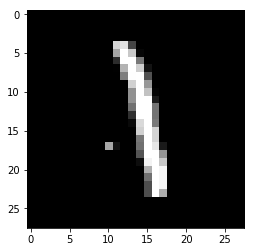

In [8]:
plt.imshow(images_train[12225],cmap='gray')

In [9]:
#the distribution of the train labels
labels_train.value_counts()

1    4209
7    3943
3    3907
9    3772
0    3742
2    3739
6    3732
4    3698
8    3664
5    3394
Name: label, dtype: int64

In [10]:
#the distribution of the validation labels
labels_val.value_counts()

1    496
2    451
3    446
7    434
9    431
6    419
8    391
0    383
4    381
5    368
Name: label, dtype: int64

In [11]:
import torch
from torch import Tensor,device
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset, DataLoader



def data_augmentation (images):
    """
    This function takes a set of Ndarray images and returnes a normalized tensor of the images after some random rotations
    
    with some random prespective repositioning.
    
    
    """
    
    
    augmented_images = torch.zeros(images.shape)
    
    image_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.RandomRotation((-20,20)),
                               transforms.RandomPerspective(distortion_scale=0.4,p=0.3),
                               transforms.ToTensor(),
                               transforms.Normalize(0.1176685 , 0.2934735)
                                         ])
    
    for indx , image in enumerate(images) :
        augmented_images[indx] = image_transform(image.reshape(28,28,1))
        
        
    
    return augmented_images


In [12]:
images_train_aug = data_augmentation(images_train) #apply the function on the train images

labels_train = Tensor(labels_train.to_list()) #tranform the ndarray of labels to a tensor


train_image_labels = TensorDataset( images_train_aug , labels_train ) #combining the train images and the labels

#the data loader from which we will load the train images and the labels
data_train = DataLoader(train_image_labels,batch_size=128,shuffle=True) 

In [13]:
#preprocessing the validation data the same as we did with the train data

images_val = images_val.astype(np.uint8)
augmented_images_val = torch.zeros(images_val.shape)
    
image_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.1325 , 0.3101)
                                         ])
    
for indx , image in enumerate(images_val) :
    augmented_images_val[indx] = image_transform(image.reshape(28,28,1))
        
images_val = augmented_images_val

labels_val = Tensor(labels_val.to_list())

In [14]:
#creating our CNN model 

import torch.nn.functional as F
from torch import nn

class CNNnet(nn.Module):
    
    def __init__(self):
        super(CNNnet,self).__init__()
        self.pad = nn.ConstantPad2d(2,0)
        
        self.conv1  = nn.Conv2d(1,16,3)
        self.pool1  = nn.MaxPool2d(2,2)
        self.drop1  = nn.Dropout(p=0.2)
        
        self.conv2  = nn.Conv2d(16,32,4)
        self.batch2 = nn.BatchNorm2d(32)
        self.pool2  = nn.MaxPool2d(2,2)
        self.drop2  = nn.Dropout(p=0.3)
        
        self.conv3  = nn.Conv2d(32,64,3)
        self.batch3 = nn.BatchNorm2d(64)
        self.pool3  = nn.MaxPool2d(2,2)
        self.drop3  = nn.Dropout(p=0.3)
        
        self.fc1    = nn.Linear(1600,800)
        self.drop4  = nn.Dropout(p=0.3)
        
        self.fc2    = nn.Linear(800,400)
        self.drop5  = nn.Dropout(p=0.2)
        
        self.fc3    = nn.Linear(400,100)
        self.drop6  = nn.Dropout(p=0.2)
        
        self.fc4    = nn.Linear(100 ,10)
        
    def forward(self , X):
        
        X = self.pad(X)   # (b,1,32,32)
        
        
        X = self.conv1(X)  # (b,16,30,30)
        X = F.relu(X)      # (b,16,30,30)
        X = self.pool1(X)  # (b,16,15,15)
        X = self.drop1(X)  # (b,16,15,15)
        
        X = self.pad(X)    # (b,16,19,19)
        
        X = self.conv2(X)  # (b,32,16,16)
        X = self.batch2(X) # (b,32,16,16)
        X = F.relu(X)      # (b,32,16,16)
        X = self.pool2(X)  # (b,32, 8, 8)
        X = self.drop2(X)  # (b,32, 8, 8)
        
        X = self.pad(X)    # (b,32,12,12)
        
        X = self.conv3(X)  # (b,64, 10, 10)
        X = self.batch3(X) # (b,64, 10, 10)
        X = F.relu(X)      # (b,64, 10, 10)
        X = self.pool3(X)  # (b,64,  5,  5)
        X = self.drop3(X)  # (b,64,  5,  5)
        
        X = X.view( ( X.size()[0], -1 ) )  # (b,1600)
        
        X = self.fc1(X)    # (b,800)
        X = F.relu(X)      # (b,800)
        X = self.drop4(X)  # (b,800)
        
        X = self.fc2(X)    # (b,400)
        X = F.relu(X)      # (b,400)
        X = self.drop5(X)  # (b,400)
        
        X = self.fc3(X)    # (b,100)
        X = F.relu(X)      # (b,100)
        X = self.drop6(X)  # (b,100)
        
        X = self.fc4(X)    # (b,10)
        X = F.log_softmax(X,dim=1)  # (b,10)
        
        return X
        
        
        
    
        
net = CNNnet()   
net

CNNnet(
  (pad): ConstantPad2d(padding=(2, 2, 2, 2), value=0)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1600, out_features=800, bias=True)
  (drop4): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (drop5): Dropout(p=0.2,

In [15]:
#defining out loss function and our optimizer

import torch.optim as optim
loss = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [16]:
#the training part :D

epoches = 20 #number of iterations over the data

# preparing the net for training
net.train()

for epoch in range (epoches):
    
    curr_loss = 0
    
    # training on batches of data from out data loader
    for batch_num , data in enumerate(data_train):
        
        net.train()
        
        # the input images and their corresponding labels
        image_batch = data[0].unsqueeze(1)
        labels_batch = data[1]
        
        # forward pass to get outputs
        probas = net(image_batch)
        
        # calculate the loss between the probabilities and the labels
        loss_batch = loss(probas,labels_batch.to(int))
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # backward pass to calculate the weight gradients
        loss_batch.backward()
        
        # update the weights
        optimizer.step()
        
        #adding the loss of that batch to our curr loss variable
        curr_loss += loss_batch.item()
        
        #every 10 batches
        if (batch_num+1) % 10 == 0 :
            
            #making our model in the evaluation mode
            net.eval()
            
            #making predictions on the val data
            probas_val = net(images_val.unsqueeze(1))
            
            #calculating the validation loss
            loss_val = loss(probas_val , labels_val.to(int)).item()
            
            print('{}/20 epoch at batch {} with loss {}  and val of  {}'.format(epoch+1, batch_num+1 , curr_loss/10 , loss_val ) )
            curr_loss = 0
            
            net.train()
        
        
        


1/20 epoch at batch 10 with loss 2.309046411514282  and val of  2.2787444591522217
1/20 epoch at batch 20 with loss 2.199526143074036  and val of  2.068939447402954
1/20 epoch at batch 30 with loss 1.8424765706062316  and val of  1.447230577468872
1/20 epoch at batch 40 with loss 1.4429009556770325  and val of  0.9274160861968994
1/20 epoch at batch 50 with loss 1.1417282938957214  and val of  0.7061378359794617
1/20 epoch at batch 60 with loss 1.0059988915920257  and val of  0.543668806552887
1/20 epoch at batch 70 with loss 0.8753390848636627  and val of  0.46005672216415405
1/20 epoch at batch 80 with loss 0.7473428905010223  and val of  0.4071677029132843
1/20 epoch at batch 90 with loss 0.7357594966888428  and val of  0.3186904788017273
1/20 epoch at batch 100 with loss 0.6963527023792266  and val of  0.2756447494029999
1/20 epoch at batch 110 with loss 0.5955925077199936  and val of  0.30221909284591675
1/20 epoch at batch 120 with loss 0.5958645015954971  and val of  0.245477646

4/20 epoch at batch 90 with loss 0.1877713069319725  and val of  0.06771129369735718
4/20 epoch at batch 100 with loss 0.17499166429042817  and val of  0.07579629123210907
4/20 epoch at batch 110 with loss 0.17410326823592187  and val of  0.07603803277015686
4/20 epoch at batch 120 with loss 0.1978868968784809  and val of  0.0746118575334549
4/20 epoch at batch 130 with loss 0.17230316549539565  and val of  0.06896357238292694
4/20 epoch at batch 140 with loss 0.18941025733947753  and val of  0.0679580345749855
4/20 epoch at batch 150 with loss 0.22937367409467696  and val of  0.07004525512456894
4/20 epoch at batch 160 with loss 0.18218351528048515  and val of  0.08469696342945099
4/20 epoch at batch 170 with loss 0.16257557310163975  and val of  0.05835748836398125
4/20 epoch at batch 180 with loss 0.19019051715731622  and val of  0.06262319535017014
4/20 epoch at batch 190 with loss 0.19393092542886733  and val of  0.08814908564090729
4/20 epoch at batch 200 with loss 0.183147114515

7/20 epoch at batch 160 with loss 0.12747140862047673  and val of  0.05183647572994232
7/20 epoch at batch 170 with loss 0.14526638612151146  and val of  0.047286201268434525
7/20 epoch at batch 180 with loss 0.13374965414404869  and val of  0.04592294618487358
7/20 epoch at batch 190 with loss 0.1248676098883152  and val of  0.055884405970573425
7/20 epoch at batch 200 with loss 0.12844398692250253  and val of  0.047568559646606445
7/20 epoch at batch 210 with loss 0.150270801410079  and val of  0.050815340131521225
7/20 epoch at batch 220 with loss 0.12390430718660354  and val of  0.04916628450155258
7/20 epoch at batch 230 with loss 0.13795013278722762  and val of  0.05563773587346077
7/20 epoch at batch 240 with loss 0.1487785466015339  and val of  0.046485014259815216
7/20 epoch at batch 250 with loss 0.13752550520002843  and val of  0.07441821694374084
7/20 epoch at batch 260 with loss 0.14160164073109627  and val of  0.05158142372965813
7/20 epoch at batch 270 with loss 0.121060

10/20 epoch at batch 230 with loss 0.11889387480914593  and val of  0.049009352922439575
10/20 epoch at batch 240 with loss 0.10080769136548043  and val of  0.05366590991616249
10/20 epoch at batch 250 with loss 0.09353114850819111  and val of  0.05714218690991402
10/20 epoch at batch 260 with loss 0.1022552102804184  and val of  0.052716463804244995
10/20 epoch at batch 270 with loss 0.09418339729309082  and val of  0.050726618617773056
10/20 epoch at batch 280 with loss 0.11670061126351357  and val of  0.0477333702147007
10/20 epoch at batch 290 with loss 0.09299135282635689  and val of  0.04590265452861786
11/20 epoch at batch 10 with loss 0.11289463266730308  and val of  0.0507250539958477
11/20 epoch at batch 20 with loss 0.12781688012182713  and val of  0.05196176841855049
11/20 epoch at batch 30 with loss 0.09902316778898239  and val of  0.045386478304862976
11/20 epoch at batch 40 with loss 0.10277350097894669  and val of  0.05307525396347046
11/20 epoch at batch 50 with loss 0

13/20 epoch at batch 290 with loss 0.10220018960535526  and val of  0.036019109189510345
14/20 epoch at batch 10 with loss 0.11060020923614503  and val of  0.03906624764204025
14/20 epoch at batch 20 with loss 0.08384739868342876  and val of  0.03516799956560135
14/20 epoch at batch 30 with loss 0.10105196125805378  and val of  0.042200177907943726
14/20 epoch at batch 40 with loss 0.09297335632145405  and val of  0.041367046535015106
14/20 epoch at batch 50 with loss 0.08920106999576091  and val of  0.03954680263996124
14/20 epoch at batch 60 with loss 0.10635529458522797  and val of  0.038232650607824326
14/20 epoch at batch 70 with loss 0.09910842962563038  and val of  0.040389496833086014
14/20 epoch at batch 80 with loss 0.07252391502261162  and val of  0.04082363843917847
14/20 epoch at batch 90 with loss 0.10045133940875531  and val of  0.03972315788269043
14/20 epoch at batch 100 with loss 0.10342501569539309  and val of  0.03560855612158775
14/20 epoch at batch 110 with loss 0

17/20 epoch at batch 60 with loss 0.09565054588019847  and val of  0.033204447478055954
17/20 epoch at batch 70 with loss 0.08548183478415013  and val of  0.03450968489050865
17/20 epoch at batch 80 with loss 0.08522621132433414  and val of  0.03694402799010277
17/20 epoch at batch 90 with loss 0.08106979504227638  and val of  0.038520921021699905
17/20 epoch at batch 100 with loss 0.07024675756692886  and val of  0.03674217313528061
17/20 epoch at batch 110 with loss 0.12851243317127228  and val of  0.039227042347192764
17/20 epoch at batch 120 with loss 0.07735123112797737  and val of  0.03965013474225998
17/20 epoch at batch 130 with loss 0.08289913609623908  and val of  0.04180599004030228
17/20 epoch at batch 140 with loss 0.08730986639857292  and val of  0.038889847695827484
17/20 epoch at batch 150 with loss 0.06118447221815586  and val of  0.037410229444503784
17/20 epoch at batch 160 with loss 0.06127188764512539  and val of  0.035656195133924484
17/20 epoch at batch 170 with 

20/20 epoch at batch 120 with loss 0.0743096588179469  and val of  0.03178934380412102
20/20 epoch at batch 130 with loss 0.0678794164210558  and val of  0.03439609333872795
20/20 epoch at batch 140 with loss 0.08596557322889567  and val of  0.03062068112194538
20/20 epoch at batch 150 with loss 0.07769159488379955  and val of  0.03355695307254791
20/20 epoch at batch 160 with loss 0.06034015119075775  and val of  0.03945092856884003
20/20 epoch at batch 170 with loss 0.08104556873440742  and val of  0.031158853322267532
20/20 epoch at batch 180 with loss 0.08533484153449536  and val of  0.03361024335026741
20/20 epoch at batch 190 with loss 0.07454095594584942  and val of  0.029783053323626518
20/20 epoch at batch 200 with loss 0.06110850740224123  and val of  0.03000568225979805
20/20 epoch at batch 210 with loss 0.0774798545986414  and val of  0.031337860971689224
20/20 epoch at batch 220 with loss 0.09567496404051781  and val of  0.03467389568686485
20/20 epoch at batch 230 with lo

In [17]:
#saving the models parameter after the training

model_dir = ''
model_name = 'mnist_model_NLL_6.pt'

torch.save(net.state_dict(), model_dir+model_name)

In [22]:
#preprocessing the test images 

test = pd.read_csv('test.csv')

images_test = test.to_numpy()

images_test = images_test.reshape((28000,28,28))

images_test = images_test.astype(np.uint8)

augmented_images_test = torch.zeros(images_test.shape)
    
image_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.1308 , 0.3083)
                                         ])
    
for indx , image in enumerate(images_test) :
    augmented_images_test[indx] = image_transform(image.reshape(28,28,1))
        


images_test = augmented_images_test

In [26]:
# finally! the time to tell fortunes !!
net.eval()

images_test = images_test.unsqueeze(1) #from (N,28,28) to (N,1,28,28)
probas = net(images_test)

predictions = probas.argmax(dim=1).tolist()

In [27]:
submit = pd.read_csv('sample_submission.csv')
submit['Label'] = np.array(predictions)

In [28]:
submit.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


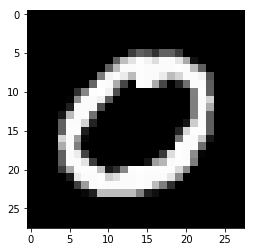

In [31]:
plt.imshow(images_test[8].squeeze(0),cmap='gray')

In [32]:
submit.to_csv('submit.csv',index=False)